In [1]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from joblib import load
from setting import *
from loader import *
from models import load_model
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *
from XAI_interpret import prediction_gap_for_an_example, get_features_order
device = torch.device('cpu')

/projects/GraphNEx/anaconda3/envs/GraphNEx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Arguments
name = "BRCA-pam"
model_name = 'LR_L1_penalty'
set_name = 'train'
exp = 1
gap = 1

In [3]:
# Path
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)
save_name = os.path.join(model_name, f"exp_{exp}")

In [4]:
# Seed
random.seed(exp)
np.random.seed(exp)

In [5]:
# Load a dataset
X_train, X_test, y_train, y_test, n_class, n_feat, class_name, feat_name = load_dataset(
    data_path, name, normalize=True)
transform = None


6356 weakly expressed genes are removed of the dataset.


In [6]:
# Load a model
model = load(os.path.join(save_path, save_name, "checkpoint.joblib"))


In [7]:
# Baseline
base_class, studied_class = get_XAI_hyperparameters(name, n_class)
baseline = get_baseline_sklearn(X_train, y_train, n_feat, base_class)
default_output = model.predict_proba(baseline)

In [8]:
# Keep only studied examples    
if set_name == "train":
    X = X_train
    y = y_train
elif set_name == "test":
    X = X_test
    y = y_test
X = X[sum(y == c for c in studied_class).astype(bool)]
y = y[sum(y == c for c in studied_class).astype(bool)]


# Keep only correctly classified examples
_class = model.predict(X)
indices = np.argwhere(y == _class).reshape(-1)
X = X[indices]
y = y[indices]


In [9]:
# Explainability scores
ordered_feat_name = np.load(os.path.join(save_path, "order", f"order_IG_LR_L1_penalty_set_train_exp_{exp}.npy"), allow_pickle=True)
ordered_indices = np.array([np.argwhere(feat == feat_name)[0] for feat in ordered_feat_name]).reshape(-1)


# Global rankings

In [10]:
rand_ex = random.randint(0, X.shape[0] - 1)

In [11]:
# PGI
global_ordering = ordered_indices.reshape(1, -1)
example = X[rand_ex].copy().reshape(1, -1)
PGI, curve_PGI = prediction_gap_for_an_example(model, example, y[rand_ex], n_class, transform, gap, 
                                          baseline, global_ordering)


sklearn


In [12]:
# PGU
global_ordering = np.flip(ordered_indices).reshape(1, -1)
example = X[rand_ex].copy().reshape(1, -1)
PGU, curve_PGU = prediction_gap_for_an_example(model, example, y[rand_ex], n_class, transform, gap, 
                                          baseline, global_ordering)


sklearn


BRCA-pam LR_L1_penalty


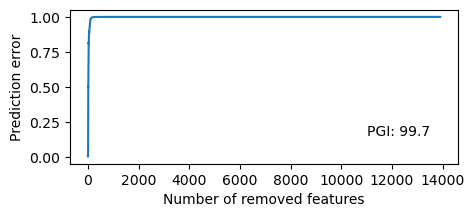

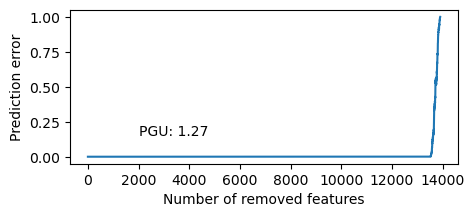

In [13]:
# Plots
print(name, model_name)
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGI) + 1) * gap, curve_PGI)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGI)) * gap, np.array([n_feat]))), curve_PGI)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction error")
plt.xlabel("Number of removed features")
plt.text(11000, 0.15, f"PGI: {np.round(PGI * 100, 2)}")
name = os.path.join(save_path, save_name, "figures", f"PGI_{set_name}")
# plt.savefig(name, bbox_inches='tight', dpi=150)
plt.show()

plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve_PGU) + 1) * gap, curve_PGU)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve_PGU)) * gap, np.array([n_feat]))), curve_PGU)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction error")
plt.xlabel("Number of removed features")
plt.text(2000, 0.15, f"PGU: {np.round(PGU * 100, 2)}")
name = os.path.join(save_path, save_name, "figures", f"PGU_{set_name}")
# plt.savefig(name, bbox_inches='tight', dpi=150)
plt.show()